# Part 2: Illness Detection
### This part determines level of illness within sheep based on sitting/standing ground truth data

In [13]:
# Imports
import pandas as pd
import numpy as np

In [16]:
# read in the data first
# note that D is missing several days
files = ['A.csv', 'B.csv', 'U.csv', 'V.csv', 'W.csv', 'D.csv']
sheep = []

for file in files:
    df = pd.read_csv(file)
    # drop unnecessary columns
    df = df.drop(columns=df.columns[3:])
    df = df.drop(columns=df.columns[0:2])

    # rename column
    df.columns = ['Standing']

    # change accelerometer value to 1 if standing, 0 if sitting
    df['Standing'] = np.where(df['Standing'] < -0.4, 1, 0)
    sheep.append(df)

Standing    1
Name: 141, dtype: int64


In [18]:
print(sheep[0].shape)
print(sheep[1].shape)
print(sheep[2].shape)
print(sheep[3].shape)
print(sheep[4].shape)
print(sheep[5].shape)

(21686, 1)
(21686, 1)
(21686, 1)
(21686, 1)
(21686, 1)
(5831, 1)


### Windowing

In [19]:
# Function to window our samples
def splitSamples(df: pd.DataFrame, samples_per_split: int) -> list:
    all_samples = []
    start_index = 0
    end_index = samples_per_split
    while end_index < len(df):
        temp_df = df[start_index:end_index]
        all_samples.append(temp_df)
        start_index += samples_per_split // 2
        end_index += samples_per_split // 2
    
    return all_samples

In [20]:
# Call the function with each dataframe to get sample lists

# The accelerometer records 2880 times a day, so let's try a window of that size
SAMPLES_PER_SPLIT = 2880
sheep[0] = splitSamples(sheep[0], SAMPLES_PER_SPLIT)
sheep[1] = splitSamples(sheep[1], SAMPLES_PER_SPLIT)
sheep[2] = splitSamples(sheep[2], SAMPLES_PER_SPLIT)
sheep[3] = splitSamples(sheep[3], SAMPLES_PER_SPLIT)
sheep[4] = splitSamples(sheep[4], SAMPLES_PER_SPLIT)
sheep[5] = splitSamples(sheep[5], SAMPLES_PER_SPLIT)


In [33]:
# Convert dataframes into just a list of sit/stand
for i in range(len(sheep)):
    for j in range(len(sheep[i])):
        sheep[i][j] = sheep[i][j]['Standing'].tolist()

### We should do feature extraction here

In [ ]:
### FEATURE EXTRACTION

### Create X and Y to prepare model

In [38]:
X = []
y = []

# Sheep have 5 levels of illness. We group these into 3 levels:
#   1 = not sick
#   2,3 = moderately sick
#   4,5 = very sick
# Sheep A, B, U, V, W, and D have sickness levels of 4, 3, 5, 1, 2, and 5 respectively
SHEEP_ILLNESS_LEVEL = [2, 1, 2, 0, 1, 2]
for s, ill in zip(sheep, SHEEP_ILLNESS_LEVEL):
    for window in s:
        X.append(window)
        y.append(ill)


### Model Creation

In [39]:
# Train and evaluate the model
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def train_and_evaluate_model(X, y, model):
    # Do the K-fold cross validation
    cv = StratifiedKFold(n_splits=10)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

    # This function sets an empty array of size len(y)
    # It then does the predictions for each fold (retraining the model each time)
    # and fills in the prediction in the correct spot in the array. By the end of it,
    # you will have your y array and a new array (predictions) of guesses for each sample
    # this is because Kfold uses each sample once for test data.
    predictions = cross_val_predict(model, X, y, cv=cv)

    # we can use this to create a confusion matrix
    new_labels = ['Not Sick', 'Moderately Sick', 'Very Sick']
    old_labels = [0, 1, 2]
    cm = confusion_matrix(y, predictions)
    plt.matshow(cm, cmap=plt.cm.Blues)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
    plt.xticks(ticks=old_labels, labels=new_labels)
    plt.yticks(ticks=old_labels, labels=new_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Label')
    
    print(f'All accuracy scores from 10 folds:')
    for score in scores:
        print(f'{round(score * 100, 2)}%', end=' ')
    print()
    print(f'Mean Accuracy from 10 Fold Cross-Validation: {round(np.mean(scores)*100, 2)}%\n')

### Testing Models

All accuracy scores from 10 folds:
62.5% 62.5% 62.5% 85.71% 71.43% 57.14% 71.43% 42.86% 57.14% 28.57% 
Mean Accuracy from 10 Fold Cross-Validation: 60.18%



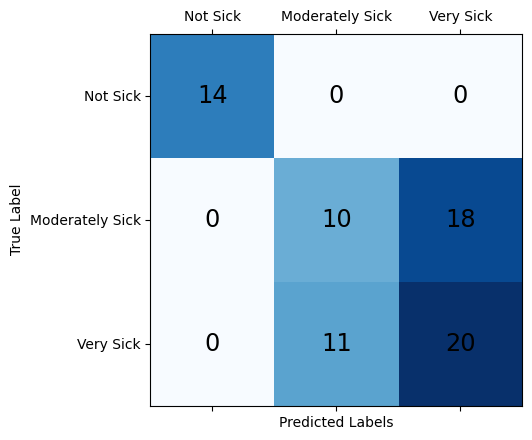

In [40]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(X, y, model)

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier()
train_and_evaluate_model(X, y, model)